In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


   Tabel of Contents
1. [Data loading & visualization.](#section1)
2. [Logistic Regression.](#section2)
3. [Decision Tree.](#section3)
4. [Random Forest.](#section4)
5. [XGBoost.](#section5)
6. [Final Results.](#section6)


# 1. Importing required libraries
<a class="anchor"  id="section1"></a>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
import itertools
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
data=pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Information about the dataset 💻📚

1. Age - Age in years 🔢
    
2. sex - sex (1 = male; 0 = female) 🚻
    
3. cp - Chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 0 = asymptomatic) 

4. trestbps - Resting blood pressure (in mm Hg on admission to the hospital)

5. chol - Serum cholestoral in mg/dl

6. fbs - Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - Maximum heart rate (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalach - Maximum heart rate achieved

9. exang - Exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - The slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. caa - Number of major vessels (0-3) colored by flourosopy

13. thall - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - The predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

In [4]:
data.info()
df=data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Data doesn't contain null values

## Renaming column names

In [5]:
df.rename(columns = {'age':'Age', 'sex':'Sex',
                              'cp':'Chest pain type','trtbps':'Resting blood pressure',
                        'chol':'Serum cholestoral','fbs':'Fasting blood sugar',
                       'restecg':'Resting electrocardiographic results','thalachh':'Maximum heart rate','exng':'Exercise induced angina',
                        'oldpeak':'ST depression','slp':'slope of the peak exercise ST segment',
                       'caa':'No.of major vessels colored by flourosopy'}, inplace = True)

## Correlation Matrix

<AxesSubplot:>

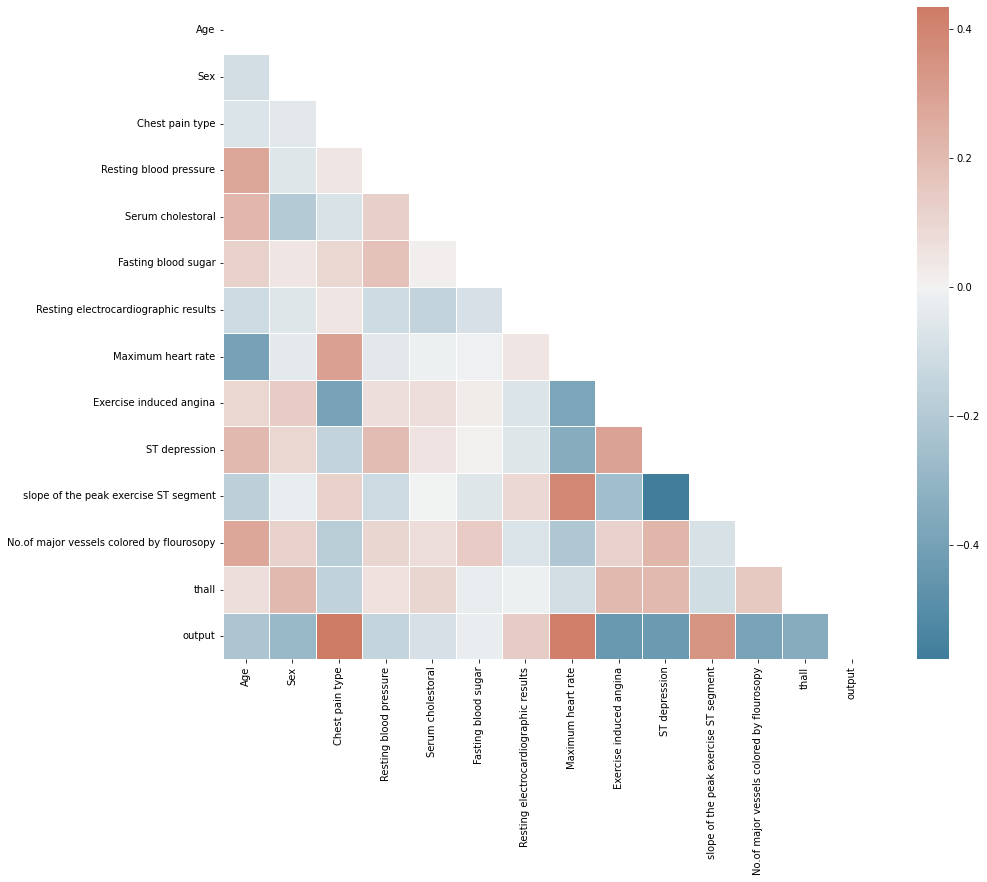

In [6]:
corr=df.corr()
mask=np.triu(np.ones_like(corr,dtype=bool))
f,ax = plt.subplots(figsize=(15,12))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corr,cmap=cmap,mask=mask,linewidth=0.5,square=True,center=0)


## Data Distribution

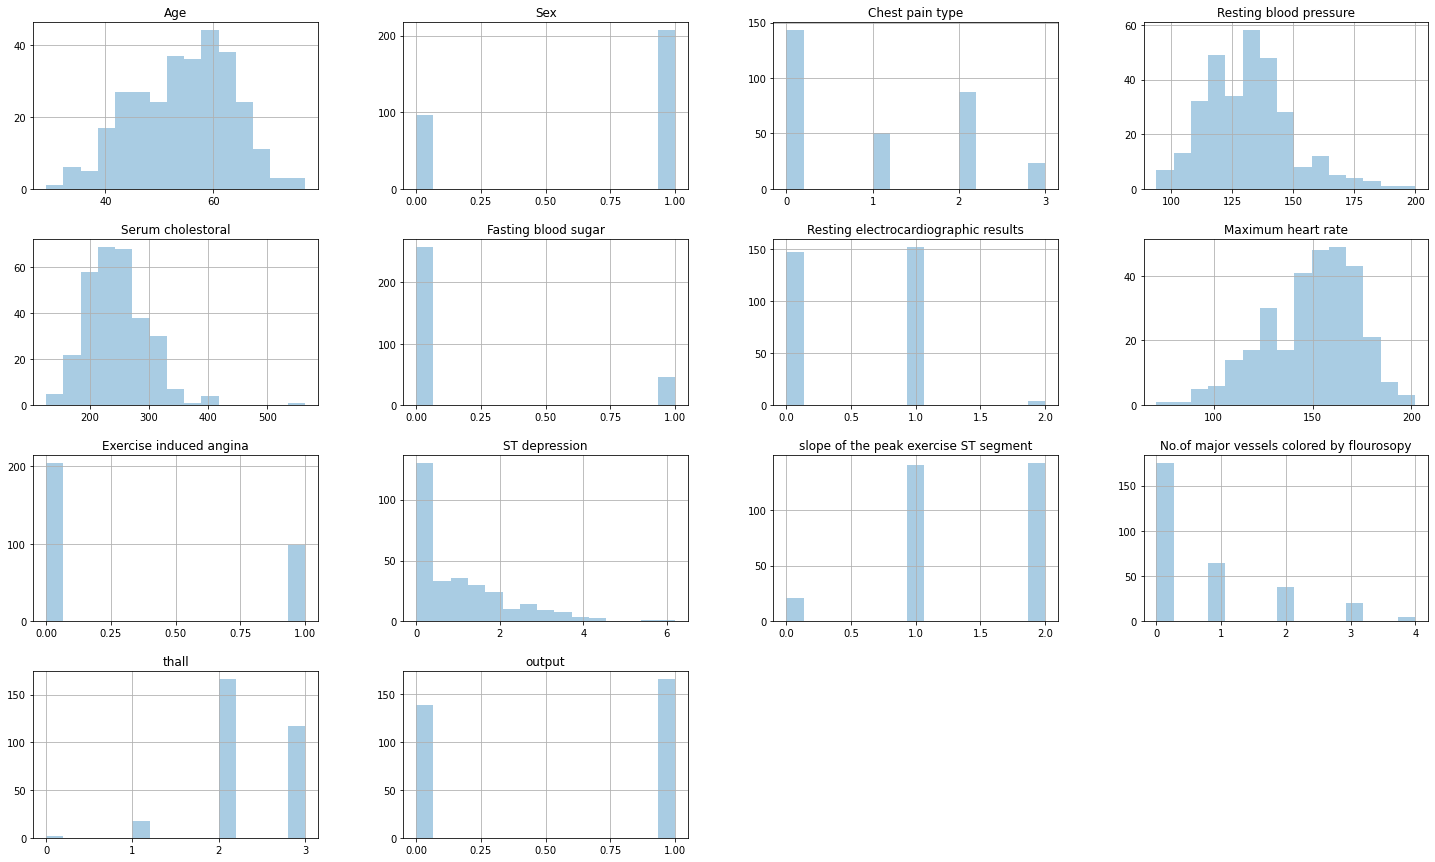

In [7]:
color = '#a9cce3'
df.hist(bins=15,figsize=(25,15),color=color)
plt.rcParams['font.size'] = 18
plt.show()

## Dividing data into Train and Test Data using Stratified Shuffle Split

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split=StratifiedShuffleSplit(n_splits=1,test_size=0.33,random_state=42)

for train_index, test_index in split.split(df, df['output']):
    strat_train_set=df.loc[train_index]
    strat_test_set=df.loc[test_index]

## Creating function to transform the data

In [9]:
def data_transformations(data):
        if 'output' in data.columns:
            labels=data['output']
            data=data.drop('output', axis=1)
        else:
            labels=None
    
        
        from sklearn.preprocessing import StandardScaler
        scaler=StandardScaler()
        data_scaled=scaler.fit_transform(data.select_dtypes(include=[np.number]))
        
        #output=np.hstack([data_scaled,data_cat_1hot])
        output=np.hstack([data_scaled,data.select_dtypes(exclude=[np.number])])
        
        return output, labels

## Transforming data

In [10]:
train_data, train_labels = data_transformations(strat_train_set)
test_data, test_labels =data_transformations(strat_test_set)

## Function to plot confusion matrix

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

## Function to print the accuracy, precision & other performance factors

In [12]:
def model_performance(cm):
    # Calculating False Positives (FP), False Negatives (FN), True Positives (TP) & True Negatives (TN)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print ("The True Positive rate / Recall per class is: ",TPR)


    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print ("The Precision per class is: ",PPV)
    
    # False positive rate or False alarm rate
    FPR = FP/(FP+TN)
    print ("The False Alarm rate per class is: ",FPR)
    
    # False negative rate or Miss Rate
    FNR = FN/(TP+FN)
    print ("The Miss Rate rate per class is: ",FNR)
    
    
    # Classification error
    CER = (FP+FN)/(TP+FP+FN+TN)
    print ("The Classification error of each class is", CER)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print ("The Accuracy of each class is", ACC)
    print("")
    
    ##Total averages :
    print ("The average Recall is: ",TPR.sum()/2)
    print ("The average Precision is: ",PPV.sum()/2)
    print ("The average False Alarm is: ",FPR.sum()/2)
    print ("The average Miss Rate rate is: ",FNR.sum()/2)
    print ("The average Classification error is", CER.sum()/2)
    print ("The average Accuracy is", ACC.sum()/2)


# 2. Logistic Regression
<a class="anchor"  id="section2"></a>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(train_data,train_labels)
yhat_lr = LR.predict(test_data)
LR

LogisticRegression(C=0.01, solver='liblinear')

Confusion matrix, without normalization
[[48  6]
 [15 31]]


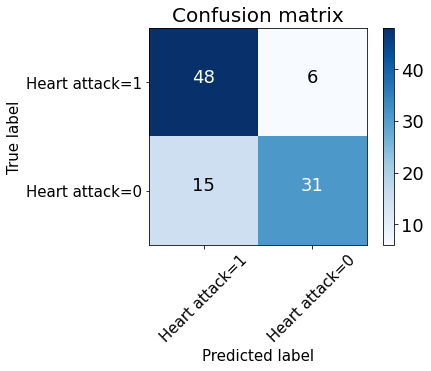

In [14]:
# Compute confusion matrix
cnf_matrix_LR = confusion_matrix(test_labels, yhat_lr, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_LR, classes=['Heart attack=1','Heart attack=0'],normalize= False,  title='Confusion matrix')

In [15]:
model_performance(cnf_matrix_LR)

The True Positive rate / Recall per class is:  [0.89 0.67]
The Precision per class is:  [0.76 0.84]
The False Alarm rate per class is:  [0.33 0.11]
The Miss Rate rate per class is:  [0.11 0.33]
The Classification error of each class is [0.21 0.21]
The Accuracy of each class is [0.79 0.79]

The average Recall is:  0.7814009661835748
The average Precision is:  0.7998712998712998
The average False Alarm is:  0.21859903381642512
The average Miss Rate rate is:  0.21859903381642512
The average Classification error is 0.21
The average Accuracy is 0.79


ROC AUC score is
0.8760064412238325


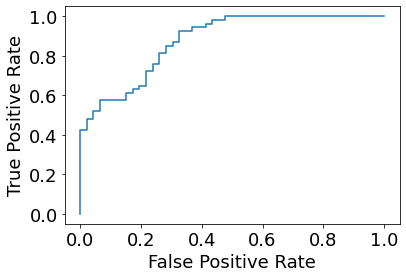

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred_proba_lr = LR.predict_proba(test_data)[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels,y_pred_proba_lr)
print('ROC AUC score is')
print(roc_auc_score(test_labels,y_pred_proba_lr))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 3. Decision Tree
<a class="anchor"  id="section3"></a>

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree_clf=DecisionTreeClassifier(criterion='entropy',max_depth=2,random_state=1)
tree_clf.fit(train_data,train_labels)

yhat_dectree = tree_clf.predict(test_data)

Confusion matrix, without normalization
[[39 15]
 [18 28]]


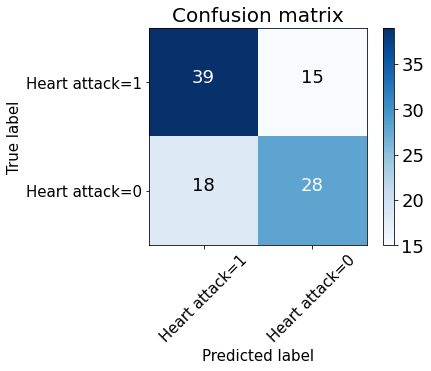

In [18]:
# Compute confusion matrix
cnf_matrix_DT = confusion_matrix(test_labels, yhat_dectree, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_DT, classes=['Heart attack=1','Heart attack=0'],normalize= False,  title='Confusion matrix')

In [19]:
model_performance(cnf_matrix_DT)

The True Positive rate / Recall per class is:  [0.72 0.61]
The Precision per class is:  [0.68 0.65]
The False Alarm rate per class is:  [0.39 0.28]
The Miss Rate rate per class is:  [0.28 0.39]
The Classification error of each class is [0.33 0.33]
The Accuracy of each class is [0.67 0.67]

The average Recall is:  0.6654589371980677
The average Precision is:  0.667686658506732
The average False Alarm is:  0.3345410628019324
The average Miss Rate rate is:  0.3345410628019324
The average Classification error is 0.33
The average Accuracy is 0.67


ROC AUC score is
0.7413446054750402


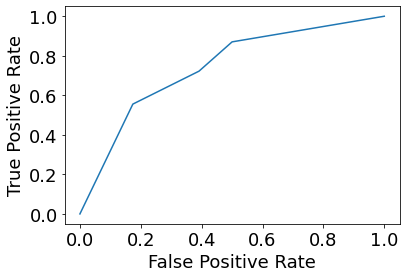

In [20]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred_proba_dt = tree_clf.predict_proba(test_data)[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels,y_pred_proba_dt)
print('ROC AUC score is')
print(roc_auc_score(test_labels,y_pred_proba_dt))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 4. Random Forest
<a class="anchor"  id="section4"></a>

In [21]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf=RandomForestClassifier(n_estimators=100,criterion='entropy')
rnd_clf.fit(train_data,train_labels)

y_pred_rf=rnd_clf.predict(test_data)


Confusion matrix, without normalization
[[47  7]
 [13 33]]


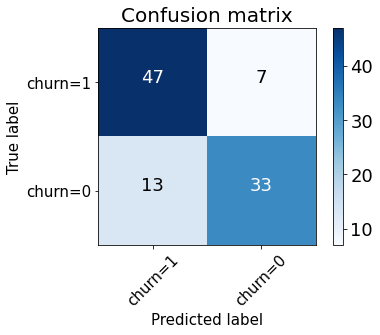

In [22]:
# Compute confusion matrix
cnf_matrix_RF = confusion_matrix(test_labels, y_pred_rf, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_RF, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [23]:
model_performance(cnf_matrix_RF)

The True Positive rate / Recall per class is:  [0.87 0.72]
The Precision per class is:  [0.78 0.82]
The False Alarm rate per class is:  [0.28 0.13]
The Miss Rate rate per class is:  [0.13 0.28]
The Classification error of each class is [0.2 0.2]
The Accuracy of each class is [0.8 0.8]

The average Recall is:  0.7938808373590982
The average Precision is:  0.8041666666666667
The average False Alarm is:  0.20611916264090174
The average Miss Rate rate is:  0.20611916264090174
The average Classification error is 0.2
The average Accuracy is 0.8


ROC AUC score is
0.8707729468599034


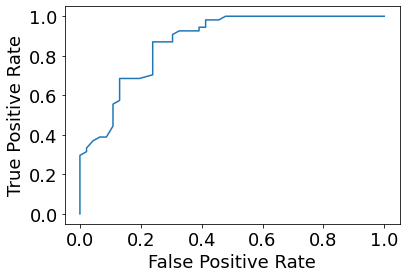

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred_proba_rf = rnd_clf.predict_proba(test_data)[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels,y_pred_proba_rf)
print('ROC AUC score is')
print(roc_auc_score(test_labels,y_pred_proba_rf))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
# Tunning Random Forest

from itertools import product
n_estimators = 100
max_features = [1, 'sqrt', 'log2']
max_depths = [None, 2,3,4,5]
for f, d in product(max_features, max_depths):
    rnd_clf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion='entropy', 
                                max_features=f, 
                                max_depth=d, 
                                n_jobs=2,
                                random_state=1337)
    rnd_clf.fit(train_data,train_labels)
    prediction_test = rnd_clf.predict(X=test_data)
    print('Classification accuracy on test set with max features = {} and max_depth = {}: {:.3f}'.format(f, d, accuracy_score(test_labels,prediction_test)))

Classification accuracy on test set with max features = 1 and max_depth = None: 0.790
Classification accuracy on test set with max features = 1 and max_depth = 2: 0.810
Classification accuracy on test set with max features = 1 and max_depth = 3: 0.810
Classification accuracy on test set with max features = 1 and max_depth = 4: 0.800
Classification accuracy on test set with max features = 1 and max_depth = 5: 0.820
Classification accuracy on test set with max features = sqrt and max_depth = None: 0.790
Classification accuracy on test set with max features = sqrt and max_depth = 2: 0.800
Classification accuracy on test set with max features = sqrt and max_depth = 3: 0.810
Classification accuracy on test set with max features = sqrt and max_depth = 4: 0.800
Classification accuracy on test set with max features = sqrt and max_depth = 5: 0.800
Classification accuracy on test set with max features = log2 and max_depth = None: 0.790
Classification accuracy on test set with max features = log2

# 5. XGBoost
<a class="anchor"  id="section5"></a>

In [26]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost

classifier=xgboost.XGBClassifier(tree_method='gpu_hist')

params={
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_depth":[2,3,4,5,6,8,10,12,15],
    "min_child_weight":[1,3,5,7],
    "gamma":[0.0,0.1,0.2,0.3,0.4],
    "colsample_bytree":[0.3,0.4,0.5,0.7]}

clf =RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='roc_auc',cv=5,verbose=3)
clf.fit(train_data,train_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=0.884 total time=   2.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=0.833 total time=   0.1s
[CV 3/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=0.959 total time=   0.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=0.914 total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5;, score=0.970 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=5, min_child_weight=7;, score=0.877 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=5, min_child_weight=7;, score=0.841 total time=   0.1s
[CV 3/5] END colsample_

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [27]:
clf.best_params_

{'min_child_weight': 5,
 'max_depth': 2,
 'learning_rate': 0.3,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [28]:
best_model=clf.best_estimator_

In [29]:
best_model.fit(train_data,train_labels)

Y_pred_xgboost = best_model.predict(test_data)

Confusion matrix, without normalization
[[47  7]
 [12 34]]


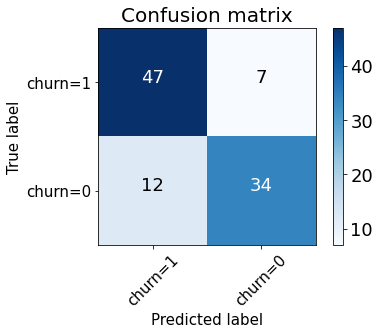

In [30]:
# Compute confusion matrix
cnf_matrix_XG = confusion_matrix(test_labels, Y_pred_xgboost, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_XG, classes=['churn=1','churn=0'],normalize= False,  title='Confusion matrix')

In [31]:
model_performance(cnf_matrix_XG)

The True Positive rate / Recall per class is:  [0.87 0.74]
The Precision per class is:  [0.8  0.83]
The False Alarm rate per class is:  [0.26 0.13]
The Miss Rate rate per class is:  [0.13 0.26]
The Classification error of each class is [0.19 0.19]
The Accuracy of each class is [0.81 0.81]

The average Recall is:  0.8047504025764896
The average Precision is:  0.8129392310872261
The average False Alarm is:  0.19524959742351045
The average Miss Rate rate is:  0.19524959742351045
The average Classification error is 0.19
The average Accuracy is 0.81


ROC AUC score is
0.9154589371980676


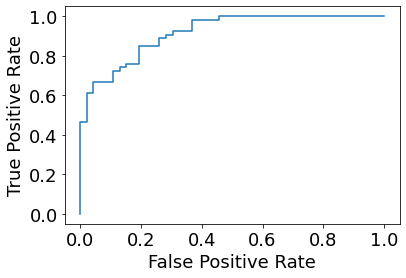

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics

y_pred_proba_xg = best_model.predict_proba(test_data)[:,1]
fpr, tpr, threshold = metrics.roc_curve(test_labels,y_pred_proba_xg)
print('ROC AUC score is')
print(roc_auc_score(test_labels,y_pred_proba_xg))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# 6. Final Results
<a class="anchor"  id="section6"></a>

In [33]:
fig = go.Figure(data=[go.Table(
                                
                                header=dict(values=['Model',
                                                    'Precision','Recall','Accuracy'],
                                line_color='#010101',
                                fill_color=' #2980b9',line_width=3,
                                align='center',
                                font=dict(color="black", size=20)),
    
                                cells=dict(values=[('Logistic Regression','Decision Tree','Random Forest','XGboost'),
                                                   ("{:.2f}".format(metrics.precision_score(test_labels, yhat_lr, pos_label=1)),
                                                    "{:.2f}".format(metrics.precision_score(test_labels, yhat_dectree, pos_label=1)),
                                                   "{:.2f}".format(metrics.precision_score(test_labels, y_pred_rf, pos_label=1)),
                                                   "{:.2f}".format(metrics.precision_score(test_labels, Y_pred_xgboost, pos_label=1))),
                                                  
                                                  ("{:.2f}".format(metrics.recall_score(test_labels, yhat_lr, pos_label=1)),
                                                  "{:.2f}".format(metrics.recall_score(test_labels, yhat_dectree, pos_label=1)),
                                                  "{:.2f}".format(metrics.recall_score(test_labels, y_pred_rf, pos_label=1)),
                                                  "{:.2f}".format(metrics.recall_score(test_labels, Y_pred_xgboost, pos_label=1))),
                                                  
                                                  ("{:.2f}".format(metrics.accuracy_score(test_labels, yhat_lr)),
                                                   "{:.2f}".format(metrics.accuracy_score(test_labels, yhat_dectree)),
                                                   "{:.2f}".format(metrics.accuracy_score(test_labels, y_pred_rf)),
                                                   "{:.2f}".format(metrics.accuracy_score(test_labels, Y_pred_xgboost)))],
                                fill_color=' #d4e6f1',line_color='#010101',line_width=3,
                                           align='center',
                                font=dict(color="#1f1f1f", size=20),height=40) 
)])

fig.update_layout(width=900, height=400,font=dict(
        family="Courier New, monospace"))
fig.show()

**Since the XGBoost model is having higher precision,recall and accuracy it can be chosen as a final model to predict heart attack.**

**If you like the notebook please do upvote and also comment to suggest improvements in the notebook.**

**Thank you 👏🙌👍.**